# Implementation of pixel-flipping algorithm (POC)

# LRP

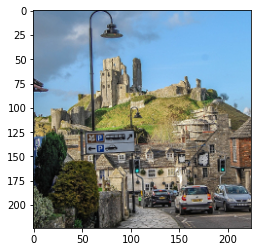

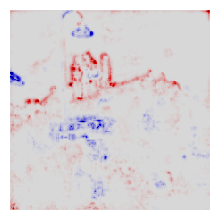

In [1]:
from typing import Callable
import torchvision
import numpy
import torch
from lrp import norm, image
from torchvision import transforms

from lrp.rules import LrpZBoxRule, LrpGammaRule, LrpEpsilonRule, LrpZeroRule

from typing import List, Dict, Union, Tuple
from lrp.filter import LayerFilter
from lrp.zennit.types import AvgPool, Linear
import lrp.rules as rules

from lrp.core import LRP

import lrp.plot
from matplotlib import pyplot as plt

# Normalization
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
# norm_fn: Callable[[torch.Tensor], torch.Tensor] = norm.ImageNetNorm()
norm_fn: Callable[[torch.Tensor], torch.Tensor] = transforms.Normalize(mean, std)

# Input data

transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Resize((224, 224)),
  transforms.ConvertImageDtype(torch.float),
  norm_fn
])

inv_normalize = transforms.Normalize(
   mean= [-m/s for m, s in zip(mean, std)],
   std= [1/s for s in std]
)

# Image is in RGB mode with range [0,1]
img: numpy.array = image.load_normalized_img('../data/castle.jpg')
X = transform(img)
# Simulate batch by adding a new dimension
X = torch.unsqueeze(X, 0)
# X=X[0]

# plt.axis('off')
plt.imshow(inv_normalize(X[0]).numpy().transpose((1, 2, 0)))

# Model
model = torchvision.models.vgg16(pretrained=True)
model.eval()

# Low and high parameters for zB-rule
batch_size: int = 1
shape: Tuple[int] = (batch_size, 3, 224, 224)

low: torch.Tensor = norm_fn(torch.zeros(*shape))
high: torch.Tensor = norm_fn(torch.ones(*shape))

# Init layer filter
vgg16_target_types: Tuple[type] = (Linear, AvgPool)
filter_by_layer_index_type = LayerFilter(model)
filter_by_layer_index_type.set_target_types(vgg16_target_types)

name_map: List[Tuple[List[str], rules.LrpRule, Dict[str, Union[torch.Tensor, float]]]]
name_map = [
    (filter_by_layer_index_type(lambda n: n == 0), LrpZBoxRule, {'low': low, 'high': high}),
    (filter_by_layer_index_type(lambda n: 1 <= n <= 16), LrpGammaRule, {'gamma': 0.25}),
    (filter_by_layer_index_type(lambda n: 17 <= n <= 30), LrpEpsilonRule, {'epsilon': 0.25}),
    (filter_by_layer_index_type(lambda n: 31 <= n), LrpZeroRule, {}),
]

from lrp.core import LRP

lrp = LRP(model)
lrp.convert_layers(name_map)
R: torch.Tensor = lrp.relevance(X)
lrp.heatmap(R, width=2, height=2)

# Pixel-flipping

In [2]:
# 483 is the index of the neuron with the highest activation. In this case, 483 stands for castle class
lrp.model.forward(X)[0][483].item()

11.028932571411133

In [3]:
r = R[0]

print(torch.aminmax(R))
print(torch.amax(r).item())
max_r = (r==torch.max(r)).nonzero()
print(max_r.shape)
z, i, h = max_r[0].tolist()

print('max_indices', max_r[0].tolist())

max_r_val = r[z, i, h].item()
print(f'r max {max_r_val}')

torch.return_types.aminmax(
min=tensor(-0.0072),
max=tensor(0.0068))
0.006813136860728264
torch.Size([1, 3])
max_indices [1, 83, 67]
r max 0.006813136860728264


## Test sampling from uniform distribution

In [4]:
from numpy.random import default_rng

rng = default_rng(seed=42)
vals = rng.uniform(low=-1, high=1, size=5)
print(vals)

[ 0.5479121  -0.12224312  0.71719584  0.39473606 -0.8116453 ]


## Algorithm

In [5]:
X.detach()[0][1,84,67]

tensor(1.5532)

Initial score: 11.028932571411133
Step 0
r_max val: 0.006813136860728264
Flipping X[0][1,2,3][83][67] to 0.5479120971119267
Score 0: 10.966526985168457
Step 1
r_max val: 0.006714589428156614
Flipping X[0][1,2,3][79][90] to -0.12224312049589536
Score 1: 10.837075233459473
Step 2
r_max val: 0.006194941699504852
Flipping X[0][1,2,3][58][95] to 0.7171958398227649
Score 2: 10.82121753692627
Step 3
r_max val: 0.005865334998816252
Flipping X[0][1,2,3][65][71] to 0.3947360581187278
Score 3: 10.763480186462402
Step 4
r_max val: 0.005456082057207823
Flipping X[0][1,2,3][102][31] to -0.8116453042247009
Score 4: 10.663773536682129
Step 5
r_max val: 0.005211216397583485
Flipping X[0][1,2,3][59][95] to 0.9512447032735118
Score 5: 10.611590385437012
Step 6
r_max val: 0.0048584602773189545
Flipping X[0][1,2,3][1][222] to 0.5222794039807059
Score 6: 10.596693992614746
Step 7
r_max val: 0.004339409526437521
Flipping X[0][1,2,3][102][21] to 0.5721286105539076
Score 7: 10.549666404724121
Step 8
r_max val:

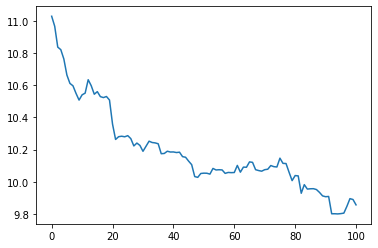

In [6]:
from numpy.random import default_rng

# Config
steps = 100
should_plot = False
plot_every = 50

rng = default_rng(seed=42)
flip_vals = rng.uniform(low=-1, high=1, size=steps)

r = R[0]

class_prediction_scores = []

X = X.detach()

# Add initial prediction score
score = lrp.model.forward(X)[0][483].item()
class_prediction_scores.append(score)
print(f'Initial score: {score}')

for i in range(steps):
    r = R[0]
    print(f'Step {i}')
    # 1. Sort by relevance
    # Get indices of max value in relevance scores
    r_max = (r==torch.max(r)).nonzero()
    j, k, l = r_max[0].tolist()
    r_max_val = r[j, k, l].item()

    # Debugging
    # print('r_max indices:', r_max[0].tolist())
    print(f'r_max val: {r_max_val}')

    # 2. Destroy pixel/patch
    print(f'Flipping X[0][1,2,3][{k}][{l}] to {flip_vals[i]}')
    X = X.detach()
    # one-RGB-channel flip
    # X[0][j, k, l] = flip_vals[i]
    
    # three-RGB-channel flip
    X[0][0, k, l] = flip_vals[i]
    X[0][1, k, l] = flip_vals[i]
    X[0][2, k, l] = flip_vals[i]
    
    if should_plot and i % plot_every == 0:
        plt.imshow(inv_normalize(X[0]).numpy().transpose((1, 2, 0)))

    # Evaluate f(x)
    # Predict updated class score
    score = lrp.model.forward(X)[0][483].item()
    print(f'Score {i}: {score}')

    R: torch.Tensor = lrp.relevance(X)
    if should_plot and i % plot_every == 0:
        lrp.heatmap(R, width=2, height=2)

    # 3. Measure decrease of f(x)
    class_prediction_scores.append(score)

plt.plot(class_prediction_scores)
plt.show()
